# Effect of regions on education level

In this project we are examing how education lavels differ acrees the five regions ind Denmark. To do this, we are using and combining two datasets from DST. One that contains population data and one that condations data for the persons highest level of education. Furthermore, to contrate the focus of the analasis we only look people in the age group 25-39 years. This is the average age for when people finish their highest level of education.

In [46]:
# Installing packages
%pip install git+https://github.com/elben10/pydst -q
%pip install pandas-datareader -q

# Importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
import seaborn as sns
import pandas_datareader
import pydst 
import seaborn as sns 

# Autoreload modules when code is run
%load_ext autoreload
%autoreload 2

# import dataproject
import dataproject

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Defining functions for later use

In [47]:
#Defining a function to extract data from DST
def get_data(table, variables_list):
    Dst = pydst.Dst(lang='en') # setup data loader with the langauge 'english'
    
    plt.rcParams.update({"axes.grid":True,"grid.color":"black","grid.alpha":"0.25","grid.linestyle":"--"})
    plt.rcParams.update({'font.size': 14})
    tables = Dst.get_tables(subjects=['2'])
    # Retrieving subjets, tables and variables
    Dst.get_subjects()
    tables = Dst.get_tables(subjects=['4'])
    tables[tables.id == table]
    indk_vars = Dst.get_variables(table_id=table)
    # Retriving data from specific tables
    variables = variables_list
    df = Dst.get_data(table_id = table, variables=variables)
    return df

#Defining a function to convert a string to float by first removing part of string
def string_to_float(variabel, strip_string):
    string = variabel.map(lambda x: x.rstrip(strip_string))
    float = string.astype('float64')
    return float
    
#Defining a function to drop certain observations
def drop_obs(df, column, value, equality = "not_equal"):
    if equality == "not_equal":
        not_dropped = df.drop(df[df[column] != value].index, inplace = True)
    return not_dropped

#Defining a function to drop variables/columns
def drop_variables(df, columns):
    not_dropped = df.drop(columns=columns, inplace = True)
    return not_dropped


# Cleaning datasat for population   

The first dataset contains population data from DST from 2010 and 2022 from every municipality in Denmark. We generate separate datasets from each year through a loop and join them afterwards using concatenation - This is done by assigning each dataset its corresponding year as the key in a dictionay.
. We only keep observations belong to the relevant age group (25 - 39 years). We sum over all age groups using the groupby function. In the end, we merge with a dataset that links each municipality to a region.

In [57]:
# Population Dataset
import itertools

# Making lists for the two years
year = [2010, 2022]
year_string = ['2010', '2022']

# Creating empty dataframe dictionary
pop_df = {}
 
# iterates over 3 lists and executes
# 2 times as len(value)= 2 which is the
# minimum among all the three
for (year, year_string) in zip(year, year_string):

    variables = {'KOMK':['*'], 'ALDER':['*'], 'TID':[year_string], 'KØN':['*'],'BYST':["*"]}
    df1 = get_data("BY2", variables)
    df = df1
    # Cleaning data, converting string to float and only keeping people in the desired agegroup (25 - 39) 
    df['ALDER'] = string_to_float(df["ALDER"], " years")
    df.loc[df['ALDER'].between(25,39), 'ALDERSGRUPPE'] = '25-39'
    # Dropping observations outside time frame and outside age group
    drop_obs(df, "TID", year, equality = "not_equal")
    drop_obs(df, "ALDERSGRUPPE", '25-39' , equality = "not_equal")
    # Summing over the variables for Municipalities
    df['total_pop'] = df.groupby(['KOMK'])['INDHOLD'].transform('sum')
    # Dropping unnecessary variables
    drop_variables(df, ['ALDER', 'BYST', "INDHOLD", "KØN", "ALDERSGRUPPE"])
    df = df.drop_duplicates(subset=("KOMK"))
    # Creating a dataframe for each year
    pop_df[year] = df

# Directing to placement of each dataset in dictionary
pop_df2010 = pop_df[2010]
pop_df2022 = pop_df[2022]

# Concatenate datasets
pop_df_concatenate = pd.concat([pop_df2010,pop_df2022])

In [58]:
# Dataser for muncipalities to regions
excel_file = "kommuneliste.xlsx"
reg_mun = pd.read_excel(excel_file)

# Changing name of København to Copenhagen so that the data sets can merge properly
reg_mun = reg_mun.replace("København", "Copenhagen")

# Merging population dataset with a dataset containing data linking municipalities to regions
pop_df_concatenate = pd.merge(reg_mun, pop_df_concatenate, how = 'inner', on = ['KOMK'])
pop_df_concatenate['total_pop_region'] = pop_df_concatenate.groupby(["TID","REGION"])['total_pop'].transform('sum')


# Cleaning datasat for educational level    

In this part, we clean the second dataset. This dataset contains education data from DST from 2010 and 2022 from every municipality in Denmark. Again, we generate separate datasets from each year through a loop and join them afterwards using concatenation and only keeping observations within the relevant age group. We only keep observations belong to the relevant age group (25 - 39 years). We sum over all age groups using the gruoby function.

We group five types of higher education as "higher education". Apart from that, we keep observations with primary education or VET as the highest education completed. 

In [59]:
# Dataset for educational level
year = [2010, 2022]
year_string = ['2010', '2022']

edu_df = {}
 
# iterates over 3 lists and executes
# 2 times as len(value)= 2 which is the
# minimum among all the three
for (year, year_string) in zip(year, year_string):

    variables = {'BOPOMR':['*'], 'ALDER':['*'], 'HFUDD':['*'], 'TID':[year_string]}
    df_hf = get_data("HFUDD11", variables)
    df_hf.rename(columns={'BOPOMR': 'KOMK', 'ALDER': 'ALDERSGRUPPE'}, inplace=True)
    drop_obs(df_hf, "TID", year , equality = "not_equal")

    ## Loop over
    age_group = ["25-29", "30-34", "35-39"]
    for x in age_group:
        df_hf.loc[df_hf['ALDERSGRUPPE'] == x + " years", 'TJEK'] = 1

    # Drops observtions not in the age group 25-39
    drop_obs(df_hf, "TJEK", 1 , equality = "not_equal")

     # Defining variabel for total education in each muncipality
    df_hf['total_in_education'] = df_hf.groupby(['KOMK', "HFUDD"])['INDHOLD'].transform('sum')
    
    # Dropping variables we are not gonna use
    drop_variables(df_hf, ["ALDERSGRUPPE", "TJEK",  "HERKOMST", "KØN", "ALDERSGRUPPE", "INDHOLD"])

    # Keeping only relevant education types
    education_list = ["H10 Primary education", "H30 Vocational Education and Training (VET)", "H40 Short cycle higher education","H50 Vocational bachelors educations", "H60 Bachelors programs","H70 Masters programs","H80 PhD programs"]
    new_education_list = ["Primary education", "VET", "Higher education", "Higher education", "Higher education", "Higher education", "Higher education"]
    for i in range(7):
        df_hf.loc[df_hf['HFUDD'] == education_list[i], 'EDUCATION'] = new_education_list[i]
    df_hf = df_hf.dropna(subset=["EDUCATION"])

    df_hf = df_hf.drop_duplicates(subset=("KOMK", "HFUDD"))
    df_hf['total_in_education'] = df_hf.groupby(["KOMK", 'EDUCATION'])['total_in_education'].transform('sum')
    
    # Drop duplicates komk and education
    df_hf = df_hf.drop_duplicates(subset=("KOMK", "EDUCATION"))
    
    # Drop variable
    drop_variables(df_hf, ["HFUDD"])

    # New dataframe

# Creating a new dataframe
    edu_df[year] = df_hf

# Dataframe for education in each of the two years
edu_df2010 = edu_df[2010]
edu_df2022 = edu_df[2022]

#Concatenate datasets
edu_df_concatenate = pd.concat([edu_df2010, edu_df2022])

# Merging the datasets

We merge the population dataset and education dataset on "Municipalities" and "Time". We use an inner join, though it does not matter since data for all municipalities exists for both years in both datasets. However, there exist some very small municipalities like Christiansø with a population of only 10 aged 25-39 years in 2022 and therefore we use an inner join to ensure that we have data from all municipalities. Finally we drop all duplicates, so that we only have the necessary data in our dataset. We group by regions and calculate the ratio of people with a certain type of education as their highest completed education in every region.

In [62]:
# Merging the datasets for population and educational level
df_merge = pd.merge(pop_df_concatenate, edu_df_concatenate, how = 'inner', on = ['KOMK', "TID"]);

# Summing over region and educational level
df_merge['total_in_education_region'] = df_merge.groupby(["TID", "REGION", 'EDUCATION'])['total_in_education'].transform('sum')
##final_df['total_pop_region'] = final_df.groupby(["TID", "REGION"])['total_pop'].transform('sum')/3

# Dropping duplicates
df_merge = df_merge.drop_duplicates(subset=("TID","REGION", "EDUCATION"))

# Drop variables that are no longer needed
drop_variables(df_merge, ['KOMK','total_pop','total_in_education'])

# Generating ratio in each region
df_merge["ratio"]=df_merge["total_in_education_region"]/df_merge["total_pop_region"]*100
df_merge = df_merge.rename(columns={'TID': 'Time'})

# Printing the final dataset
df_merge

,REGION,Time,total_pop_region,EDUCATION,total_in_education_region,ratio
0,Region Hovedstaden,2010,372412,Primary education,57615,15.470769
1,Region Hovedstaden,2010,372412,VET,85458,22.947166
2,Region Hovedstaden,2010,372412,Higher education,173403,46.562141
3,Region Hovedstaden,2022,419307,Primary education,45791,10.920638
4,Region Hovedstaden,2022,419307,VET,64660,15.420682
5,Region Hovedstaden,2022,419307,Higher education,272618,65.016325
179,Region Sjælland,2010,133024,Primary education,27943,21.005984
180,Region Sjælland,2010,133024,VET,54532,40.994106
181,Region Sjælland,2010,133024,Higher education,36648,27.549916
182,Region Sjælland,2022,131089,Primary education,26643,20.324360


# Analysis

Education is essential to human development and is considered a key component of economic growth. It is therefore important to keep an eye on how the level of education develops in the individual regions, in order to identify the regions where political intervention may be needed. In this analysis, we focus primarily on the level of education in the five regions of Denmark. Specifically, we examine the distribution of educational level among the population and how it varies across regions and over time. By understanding the patterns and trends in educational attainment, it is possible for politicians to direct resources towards the educational initiatives that will need it most.

Below is a bar chart of the ratio of people with primary education in the five regions in 2010 and 2022. The x-axis shows the different regions and the y-axis shows the ratio of people with primary education in percentage. The bars are color coded by year, with the blue representing 2010 and the orange representing 2022.

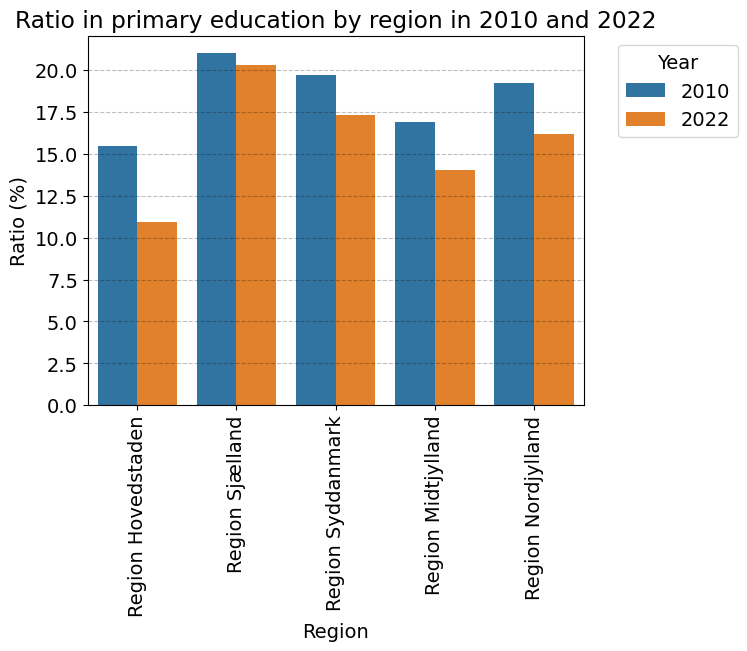

In [64]:
# Filter to primary education in 2010 and 2022
df_primary = df_merge[(df_merge['EDUCATION'] == 'Primary education') & (df_merge['Time'].isin([2010, 2022]))]

# Create bar plot
sns.barplot(data=df_primary, x='REGION', y='ratio', hue='Time')

# Rotate x-axis labels
plt.xticks(rotation=90)

# Set axis labels and title
plt.xlabel('Region')
plt.ylabel('Ratio (%)')
plt.title('Ratio in primary education by region in 2010 and 2022')

# Add legend
plt.legend(title='Year', bbox_to_anchor=(1.05, 1), loc='upper left')

The plot shows that the ratio between people with a primary education varies across the different regions in Denmark. In addition, we can see that the total proportion of people with only a primary education has fallen in all regions between 2010 and 2022. Here, it is the 'Region Hovedstaden' in particular that stands out with a drop of 5 per cent. from 2010 to 2022, but they have also been somewhat below the other regions from the start. Thus, we can say that the 'Region Hovedstaden' is the region in Denmark that has moved the most in terms of how many people take more education after primary school.

Below is a bar chart of the ratio of people with a vocational education in the five regions in 2010 and 2022. The x-axis shows the different regions and the y-axis shows the ratio of people with a vocational education in percentage. The bars are color coded by year, with the blue representing 2010 and the orange representing 2022.

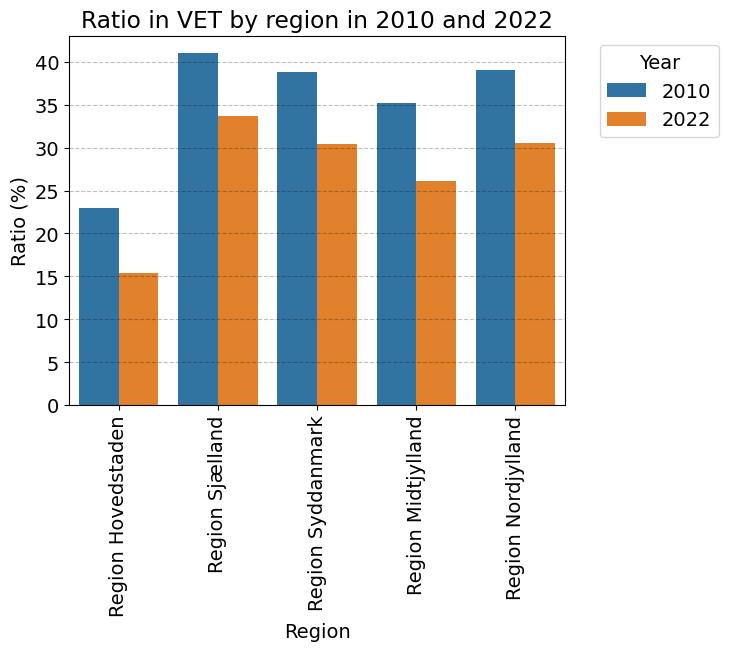

In [65]:
# Filter to VET in 2010 and 2022
df_VET = df_merge[(df_merge['EDUCATION'] == 'VET') & (df_merge['Time'].isin([2010, 2022]))]

# Create bar plot
sns.barplot(data=df_VET, x='REGION', y='ratio', hue='Time')

# Rotate x-axis labels
plt.xticks(rotation=90)

# Set axis labels and title
plt.xlabel('Region')
plt.ylabel('Ratio (%)')
plt.title('Ratio in VET by region in 2010 and 2022')

# Add legend
plt.legend(title='Year', bbox_to_anchor=(1.05, 1), loc='upper left')

The plot shows that the ratio between people with a vocational education varies across the different regions in Denmark. In addition, we can see that the total proportion of people with a vocational education has fallen approx. the same in all regions between 2010 and 2022. However, it is again particularly the 'Region Hovedstaden' that stands out with far fewer vocational graduates than the remaining regions. This is a problem that is frequently discussed by politicians, as it i.a. has led to a shortage of craftsmen and thus sky-high prices in Denmark.

Below is a bar chart of the ratio of people with a higher education in the five regions in 2010 and 2022. The x-axis shows the different regions and the y-axis shows the ratio of people with a higher education in percentage. The bars are color coded by year, with the blue representing 2010 and the orange representing 2022.

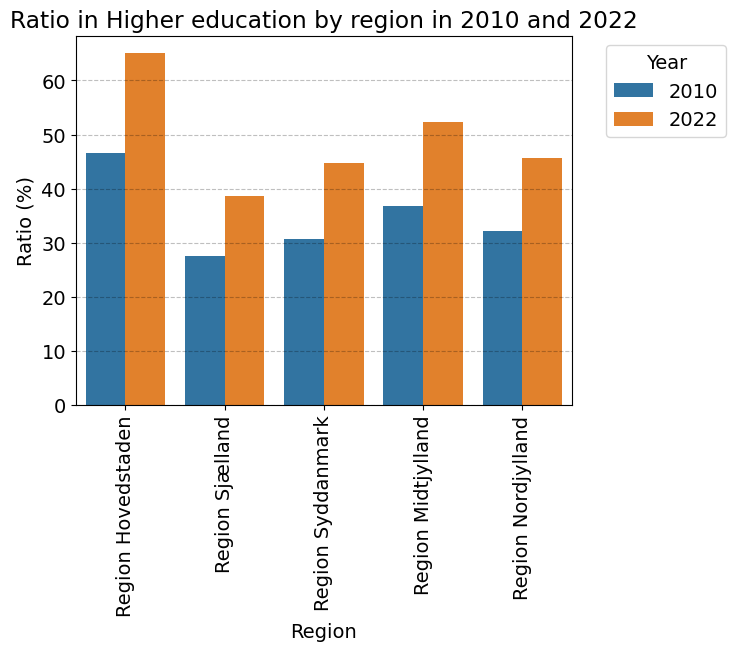

In [66]:
# Filter to higher education in 2010 and 2022
df_higher = df_merge[(df_merge['EDUCATION'] == 'Higher education') & (df_merge['Time'].isin([2010, 2022]))]

# Create bar plot
sns.barplot(data=df_higher, x='REGION', y='ratio', hue='Time')

# Rotate x-axis labels
plt.xticks(rotation=90)

# Set axis labels and title
plt.xlabel('Region')
plt.ylabel('Ratio (%)')
plt.title('Ratio in Higher education by region in 2010 and 2022')

# Add legend
plt.legend(title='Year', bbox_to_anchor=(1.05, 1), loc='upper left')

The plot shows that the ratio between people with a higher education varies across the different regions in Denmark. In addition, we can see that the total proportion of people with a higher education has increased in all regions between 2010 and 2022. However, it is again particularly the 'Region Hovedstaden' that stands out with far more highly educated people than the remaining regions. This large increase in highly educated people is, among other things, the explanation for why we lack vocational graduates in 2022.

# Conclusion

Based on the analysis, it is clear that there have been changes in the education levels across different regions of Denmark from 2010 to 2022. We see that all five regions have received a higher level of education on average, as primary education has fallen in all regions. This means that since 2010 there are more people who have taken a longer education than primary education. The same trend is observed for the VET education level where we see that less people have chosen to take a VET. It is interesting to note that the Region Hovedstaden has consistently had a lower ratio of people with primary education and VET education compared to other regions.

On the other hand, all regions have seen an increase in the ratio of people with higher education. However, once again, Region Hovedstaden stands out as the region with the highest ratio of people with higher education compared to other regions.

In conclusion, the education levels in Denmark have undergone changes over the years, with some regions showing a decline in certain education levels while others have seen an increase in higher education. These insights can help policymakers make informed decisions to address the disparities in education levels across different regions of the country.